## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import time

%matplotlib inline

In [2]:
# Load Data sets
car_images = glob.glob('./vehicles/**/*.png')
notcar_images = glob.glob('./non-vehicles/**/*.png')

Length of car images: 8792, length of non car images:8968


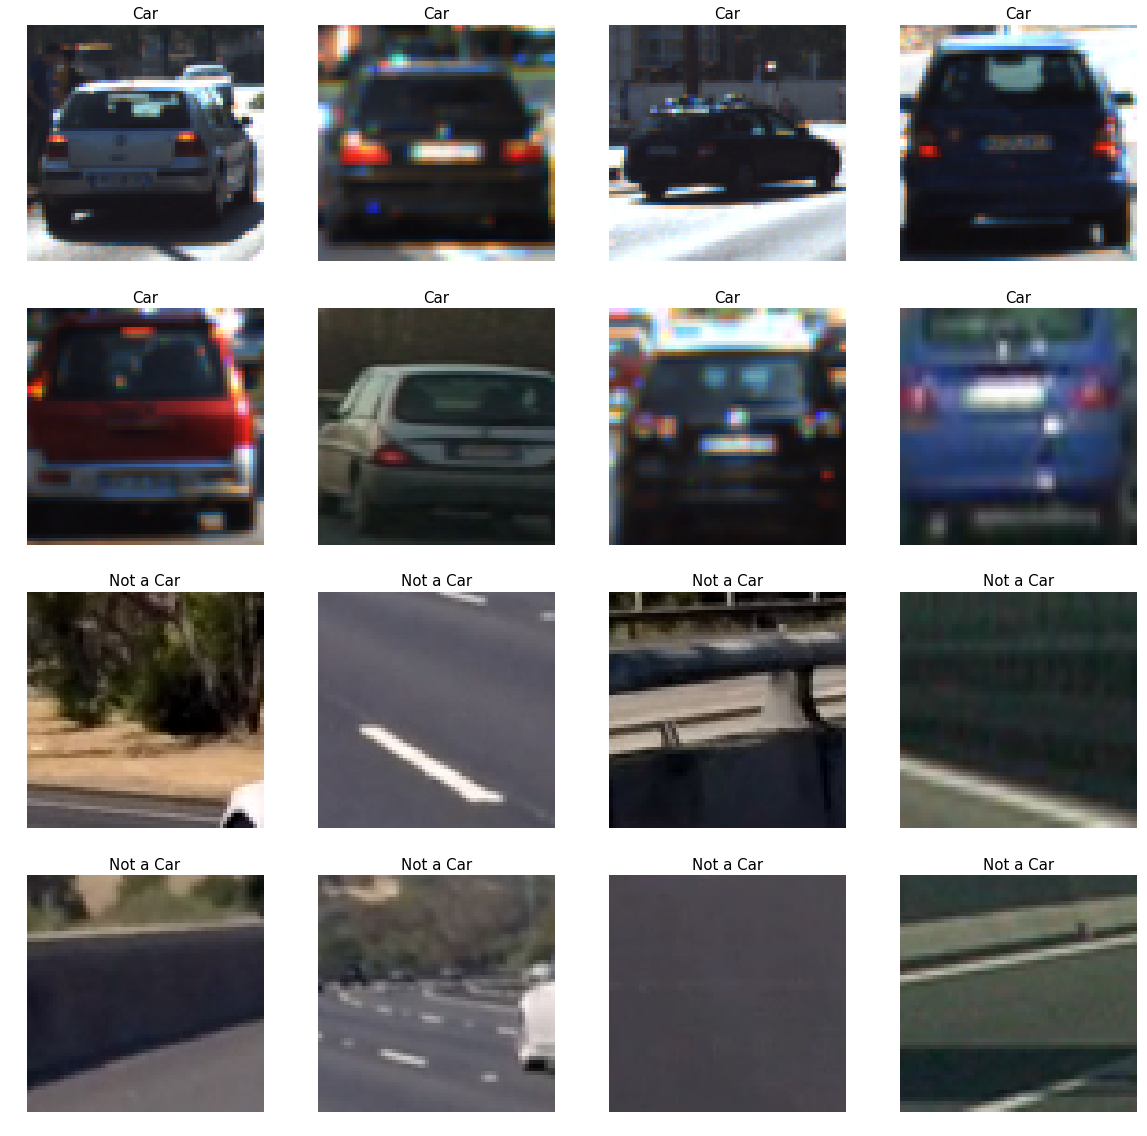

In [3]:
print('Length of car images: ' + str(len(car_images)) + ', ' + 'length of non car images:' + str(len(notcar_images)))
# Data visualisation
fig,axs = plt.subplots(4,4, figsize = (20,20))
axs = axs.ravel()
### Car Images ###
for i in range(8):
    img = mpimg.imread(car_images[np.random.randint(0,len(car_images))])
    axs[i].axis('off')
    axs[i].set_title('Car', fontsize = 15)
    axs[i].imshow(img)
for i in range(8,16):
    img = mpimg.imread(notcar_images[np.random.randint(0,len(notcar_images))])
    axs[i].axis('off')
    axs[i].set_title('Not a Car', fontsize = 15)
    axs[i].imshow(img)

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

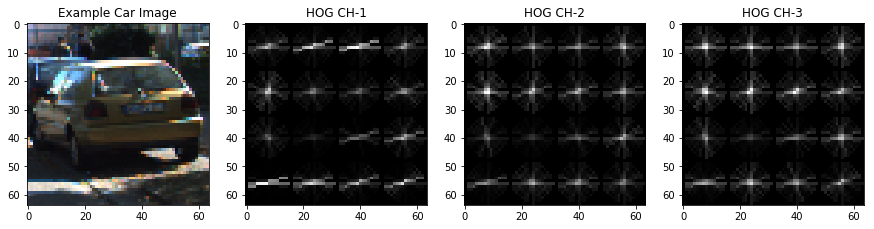

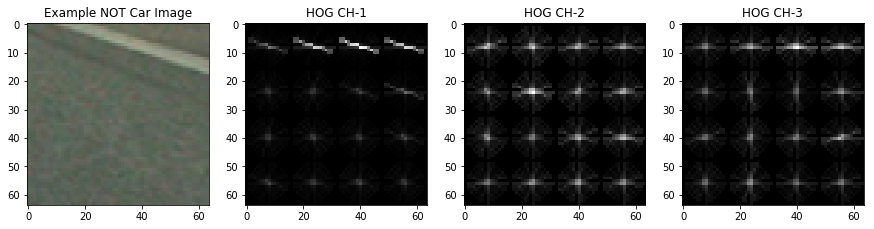

In [5]:
# Generate a random index to look at a car and noncar image
ind_car = np.random.randint(0, len(car_images))
ind_notcar = np.random.randint(0, len(notcar_images))
# Read in the image
image_car = mpimg.imread(car_images[ind_car])
car_ycr = cv2.cvtColor(image_car, cv2.COLOR_RGB2YCrCb)
##
image_notcar = mpimg.imread(notcar_images[ind_notcar])
notcar_ycr = cv2.cvtColor(image_notcar, cv2.COLOR_RGB2YCrCb)

# Call our function with vis=True to see an image output
features_car, hog_imagecar0 = get_hog_features(car_ycr[:,:,0], orient= 16, 
                        pix_per_cell= 16, cell_per_block= 2, 
                        vis=True, feature_vec=True)
# Call our function with vis=True to see an image output
features_notcar, hog_imagenotcar0 = get_hog_features(notcar_ycr[:,:,0], orient= 16, 
                        pix_per_cell= 16, cell_per_block= 2, 
                        vis=True, feature_vec=True)
# Call our function with vis=True to see an image output
features_car, hog_imagecar1 = get_hog_features(car_ycr[:,:,1], orient= 16, 
                        pix_per_cell= 16, cell_per_block= 2, 
                        vis=True, feature_vec=True)
# Call our function with vis=True to see an image output
features_notcar, hog_imagenotcar1 = get_hog_features(notcar_ycr[:,:,1], orient= 16, 
                        pix_per_cell= 16, cell_per_block= 2, 
                        vis=True, feature_vec=True)
# Call our function with vis=True to see an image output
features_car, hog_imagecar2 = get_hog_features(car_ycr[:,:,2], orient= 16, 
                        pix_per_cell= 16, cell_per_block= 2, 
                        vis=True, feature_vec=True)
# Call our function with vis=True to see an image output
features_notcar, hog_imagenotcar2 = get_hog_features(notcar_ycr[:,:,2], orient= 16, 
                        pix_per_cell= 16, cell_per_block= 2, 
                        vis=True, feature_vec=True)


# Plot the examples
f, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(15,15))
ax1.imshow(image_car, cmap='gray')
ax1.set_title('Example Car Image')
ax2.imshow(hog_imagecar0, cmap='gray')
ax2.set_title('HOG CH-1')
ax3.imshow(hog_imagecar1, cmap='gray')
ax3.set_title('HOG CH-2')
ax4.imshow(hog_imagecar2, cmap='gray')
ax4.set_title('HOG CH-3')
f, ((ax5, ax6, ax7, ax8)) = plt.subplots(1, 4, figsize=(15,15))
ax5.imshow(image_notcar, cmap='gray')
ax5.set_title('Example NOT Car Image')
ax6.imshow(hog_imagenotcar0, cmap='gray')
ax6.set_title('HOG CH-1')
ax7.imshow(hog_imagenotcar1, cmap='gray')
ax7.set_title('HOG CH-2')
ax8.imshow(hog_imagenotcar2, cmap='gray')
ax8.set_title('HOG CH-3')

In [6]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0,256)):
    img=img*255
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

    bin_edges=channel1_hist[1]
    #calculating bin center
    bin_centers = (bin_edges[1:]+bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    return hist_features


In [7]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            #print('spatial')
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            #print('Color Histogram')
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
            #features.append(hog_features)
    # Return list of feature vectors
    return features

In [8]:
color_space = 'YCrCb'
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
orient = 16  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
#y_start_stop = [None, None] # Min and max in y to search in slide_window()
sh = True


In [9]:
car_features = extract_features(car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcar_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


In [10]:
# Label Vector
y = np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features))))
# Creating an array stack from feature vvecto. Datatype is float64 because of Standarscaler
X = np.vstack((car_features, notcar_features)).astype(np.float64)

In [11]:
# Data splitting
rand_state = np.random.randint(0,100)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state = rand_state)

In [12]:
## This should be here--> I am using combined method
global X_scaler,svc
from sklearn.svm import SVC
sc = True
if sc:
    X_scaler = StandardScaler().fit(X_train)
    scaled_X_train = X_scaler.transform(X_train)
    scaled_X_test = X_scaler.transform(X_test)
    ## Classifier
    svc = SVC(kernel='rbf')
    svc.fit(scaled_X_train,y_train)
    print('test accuracy of SVC:', svc.score(scaled_X_test,y_test))
    ## Predictions

    print('My SVC predicts: ', svc.predict(scaled_X_test[0:10]))
    print('For Labels: ',y_test[0:10])

else:
    svc = LinearSVC()
    svc.fit(X_train,y_train)
    print('test accuracy of SVC:', svc.score(X_test,y_test))
    ## Predictions

    print('My SVC predicts: ', svc.predict(X_test[0:10]))
    print('For Labels: ',y_test[0:10])




test accuracy of SVC: 0.9923986486486487
My SVC predicts:  [0. 0. 1. 1. 0. 1. 1. 1. 1. 1.]
For Labels:  [0. 0. 1. 1. 0. 1. 1. 1. 1. 1.]


In [13]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, color_space, svc,X_scaler,
              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,hog_channel,sh):
   
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)      
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    rectangles = []
   
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL':
                
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            else: 
                hog_features = hog_feat1
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
 
            if sh:
                 # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)
            else:
                test_prediction = svc.predict(hog_features.reshape(1,-1))
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))) 
                
    return rectangles

In [14]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

4 possible cars


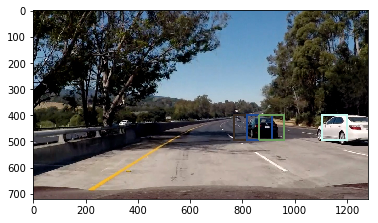

In [15]:

ystart = 400
ystop = 656
scale = 1.5
test_image = mpimg.imread('./test_images/test5.jpg')
rectangles = find_cars(test_image, ystart, ystop, scale, color_space, svc,X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,hog_channel,sh)
print(len(rectangles), 'possible cars')
rect_on_image = draw_boxes(test_image,rectangles)
plt.imshow(rect_on_image)

In [16]:
def apply_sliding_window(test_image):
    rectangles = []
    ystart = 400
    ystop = 500
    scale = 1
    rectangles .append(find_cars(test_image, ystart, ystop, scale, color_space, svc,X_scaler, orient, pix_per_cell,
                                 cell_per_block, spatial_size, hist_bins,hog_channel,sh))
    ystart = 400
    ystop = 500
    scale = 1.3
    rectangles .append(find_cars(test_image, ystart, ystop, scale, color_space, svc,X_scaler, orient, pix_per_cell,
                                 cell_per_block, spatial_size, hist_bins,hog_channel,sh))
    ystart = 410
    ystop = 500
    scale = 1.4
    rectangles .append(find_cars(test_image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell,
                                 cell_per_block, spatial_size, hist_bins,hog_channel,sh))
    ystart = 420
    ystop = 556
    scale = 1.6
    rectangles .append(find_cars(test_image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell,
                                 cell_per_block, spatial_size, hist_bins,hog_channel,sh))
    ystart = 430
    ystop = 556
    scale = 1.8
    rectangles .append(find_cars(test_image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell,
                                 cell_per_block, spatial_size, hist_bins,hog_channel,sh))
    ystop = 556
    scale = 2.0
    rectangles .append(find_cars(test_image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell,
                                 cell_per_block, spatial_size, hist_bins,hog_channel,sh))
    ystart = 440
    ystop = 556
    scale = 2.3
    rectangles .append(find_cars(test_image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell,
                                 cell_per_block, spatial_size, hist_bins,hog_channel,sh))
    ystart = 400
    ystop = 556
    scale = 1.3
    rectangles .append(find_cars(test_image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell,
                                 cell_per_block, spatial_size, hist_bins,hog_channel,sh))
    ystart = 400
    ystop = 556
    scale = 2.2
    rectangles .append(find_cars(test_image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell,
                                 cell_per_block, spatial_size, hist_bins,hog_channel,sh))
    ystart = 500
    ystop = 656
    scale = 3.0
    rectangles .append(find_cars(test_image, ystart, ystop, scale, color_space, svc, X_scaler, orient, pix_per_cell,
                                 cell_per_block, spatial_size, hist_bins,hog_channel,sh))
    return rectangles

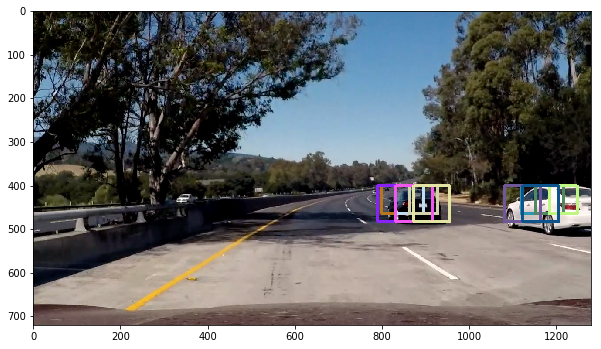

In [17]:
test_image = mpimg.imread('./test_images/test5.jpg')
rectangles = apply_sliding_window(test_image)
rectangles = [item for sublist in rectangles for item in sublist]
rects_on_image = draw_boxes(test_image, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(rects_on_image)

In [18]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [19]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [20]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

2 cars found


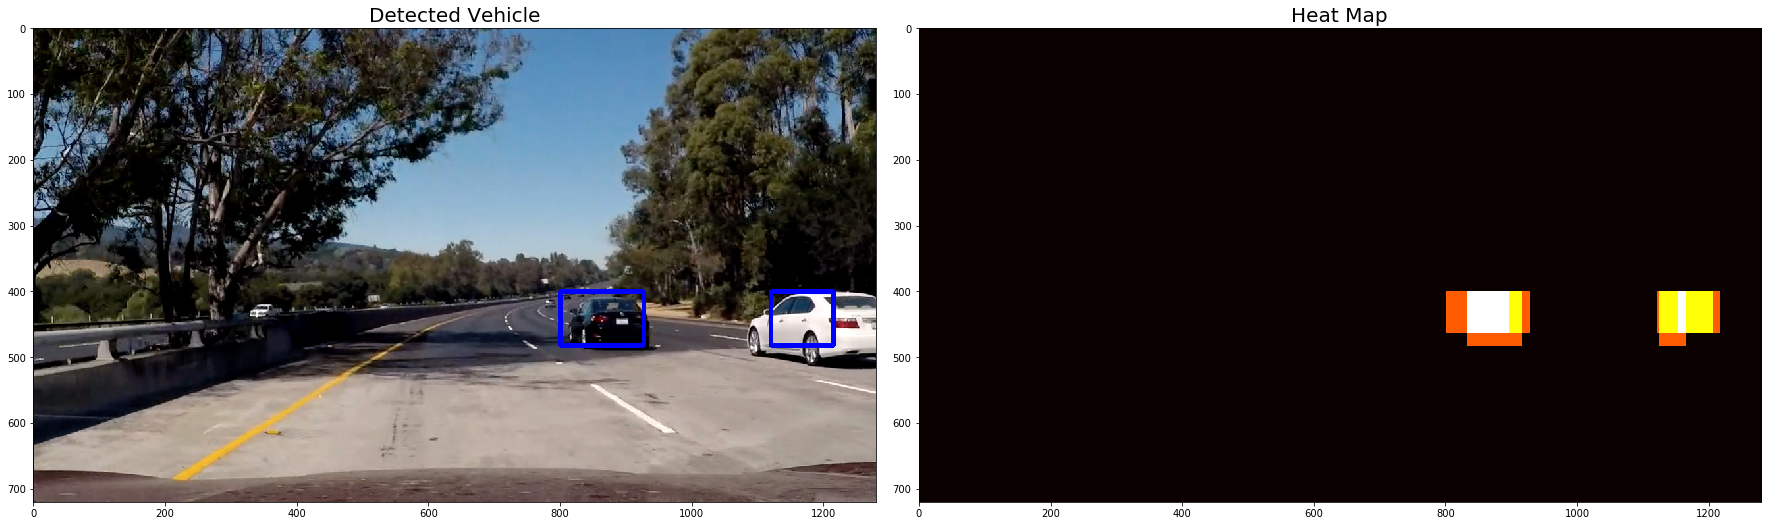

In [21]:
from scipy.ndimage.measurements import label
heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,rectangles) 
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
print(labels[1], 'cars found')
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Detected Vehicle', fontsize=20)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [24]:
def test_pipeline(image):
    rectangles = apply_sliding_window(image)
    rectangles = [item for sublist in rectangles for item in sublist]
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, rectangles)
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img,heatmap

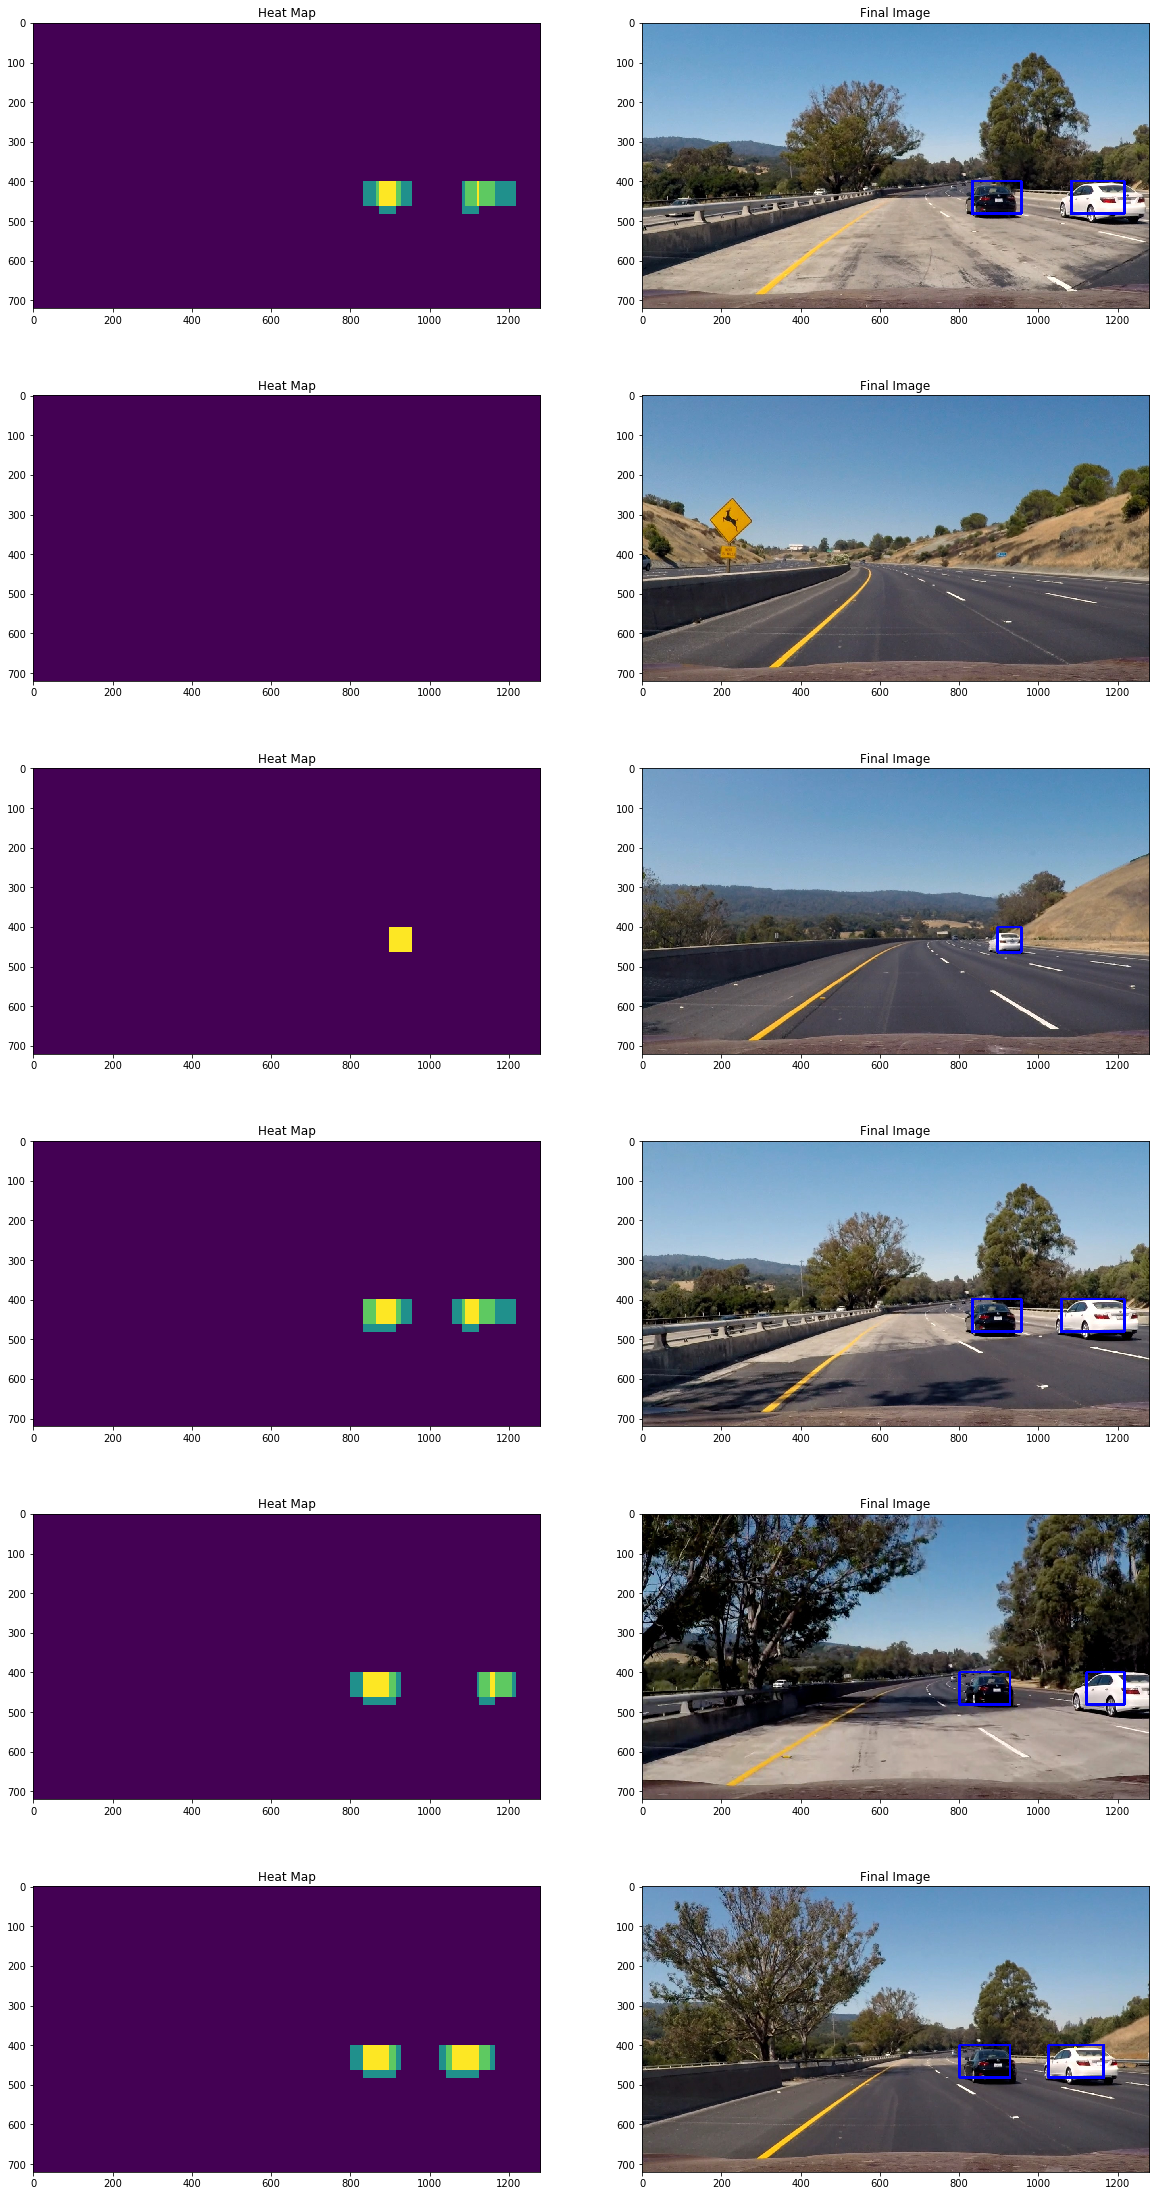

In [25]:
test_images= glob.glob("./test_images/*.jpg")
f, axes= plt.subplots(6,2, figsize=(20,40))
for index,image in enumerate(test_images):
    image = mpimg.imread(image)
    resultPic,heat_img = test_pipeline(image)
    axes[index,0].imshow(heat_img)
    axes[index,0].set_title("Heat Map")
    axes[index,1].imshow(resultPic)
    axes[index,1].set_title("Final Image")

In [27]:
class VehicleDetect():
    def __init__(self):
        self.prev_rects = []
    def add_new_rects(self,rects):
        self.prev_rects.append(rects)
        # at least five
        if len(self.prev_rects)>15:
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

In [28]:
def pipeline(image):
    rectangles = apply_sliding_window(image)
    rectangles = [item for sublist in rectangles for item in sublist]
    if len(rectangles)>0:
        vehdet.add_new_rects(rectangles)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)    
    for each in vehdet.prev_rects:
        heat = add_heat(heat, each)
    heat = apply_threshold(heat,9)#1 + len(vehdet.prev_rects)//2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [29]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [28]:

#from collections import deque
#history = deque(maxlen = 8)
#vehdet = VehicleDetect()
#out_file = 'test_video_output.mp4'
#clip_test = VideoFileClip('test_video.mp4')
#clip_test_out = clip_test.fl_image(pipeline)
#%time clip_test_out.write_videofile(out_file, audio=False)

In [30]:
#vehdet = VehicleDetect()
# Create history for 30 frames
#history = deque(maxlen=15)
vehdet = VehicleDetect()
proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4')#.subclip(0,15)  # subclip = only specified span of video
clip_proj_out = clip_proj.fl_image(pipeline)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [10:45<00:00,  1.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 10min 46s
